In [116]:
#run this cell to install the following libraries!

#install.packages("tidymodels")  #install if necessary
#install.packages("tidyverse")   #install if necessary
#install.packages("repr")        #install if necessary
#install.packages("GGally")      #install if necessary
#install.packages("plotly")       #install if necessary
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(plotly)

# Title: Predicting the Probability of Wildfire in Algerian Forests

## Introduction:

While the North-African nation of Algeria is perhaps best known for occupying a significant part of the Sahara Desert, the country is also host to a large section of the Atlas Mountains. The elevations offered by the range provide a refuge from the aridity of the desert below for many species of vegetation and fauna, and consequently these areas contain the country's most productive ecosystems (Kharytonov et al., 2018). This ecological zone also provide the ideal environment for a host of human economic activity - directly through forestry, which makes up 5% of Algeria's gross domestic product, and indirectly as productive agricultural land (Berdikeeva, 2019). As a vegetated zone in a warm alpine environment, wildfires have been always been a part of the ecosystems of Northern Algeria, providing a way for ageing forests to regenerate. However, the rate at which wildfires are occuring in the region has accelerated as global temperatures continue to increase, causing much damage both to the natural ecosystems, and to the livelihoods of the people who inhabit the region (Law, 2019). Subsequently, the Algerian authorities have put significant resources into the process of mitigating the destruction that these fires cause, but there is still a lot of work that needs doing (Meddour-Sahar et al., 2013). 

Therefore, this project seeks to provide assistance to the General Directorate of Forestry (Algeria's national department of forestry), through the creation of a machine learning classification model that can predict if a particular forest stand is likely to be the immediate scene of a fire, through several predictive factors, which will be examined below. More specifically, this project will attempt to predict wildfires in two regions of Algeria: the northeastern region of Bejaja and the northwestern region of Sidi Bel-abbes. The two regions from the dataset will be analyzed together such that data from both regions will be used to train the model. The predictor variables include **insert predictors when picked**. This will then be used to predict our target variable, which will be the fire status of the forest stand. There will be two possible classes: fire or not a fire.

This model will answer the question: 

"Can **insert predicitve variables** be used to predict whether a future wildfire will or will not occure in the Northern forests of Algeria?"

The classification model will be trained using the Algerian Forest Fires Dataset from the UCI Machine Learning Repository. The dataset contains 244 recorded fires that occured in the two regions (Bejaja and Sidi Bel-abbes) between June and September in 2012. For each observed fire, 11 attributes of the forest stand in question were recorded. These attributes were:

- Temperature (Celsius)
- Relative Humidity (%)
- Wind Speed (km/h)
- Rain (mm)
- Fine Fuel Moisture Code 
- Duff Moisture Code
- Drought Code 
- Initial Spread Index
- Build Up Index
- Fire Weather Index
- If a fire was observed at the forest stand (fire/not fire)

The final column will be used as the target variable for this model. 

## Methodology

### Preliminary Exploratory Data Analysis: 

The first step to creating the model is reading in the Algerian Forest Fires Dataset from the UCI Machine Learning Repository. This was done below using the "read_csv" function from the tidyverse package. The predictor variables were then mutated, so that they were in numeric format, while the target variable was mutated into a factor. The data is shown in "tidy" format in Table 1 below. A seed has also been set to ensure the results are reproducible. 

In [117]:
set.seed(1)

In [118]:
forest_fire_original <- read_csv(url("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv"), skip = 1)
#head(forest_fire_original)

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_character(),
  Temperature = col_character(),
  RH = col_character(),
  Ws = col_character(),
  Rain = col_character(),
  FFMC = col_character(),
  DMC = col_character(),
  DC = col_character(),
  ISI = col_character(),
  BUI = col_character(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“2 parsing failures.
row col   expected     actual         file
123  -- 14 columns 1 columns  <connection>
168  -- 14 columns 13 columns <connection>
”


In [119]:
forest_fire <- forest_fire_original %>%
  select(-day, -month, -year) %>%
  slice(1:122, 125:167, 169:244) %>%
  mutate(Temperature = as.numeric(Temperature)) %>%
  mutate(RH = as.numeric(RH)) %>%
  mutate(Ws = as.numeric(Ws)) %>%
  mutate(Rain = as.numeric(Rain)) %>%
  mutate(FFMC = as.numeric(FFMC)) %>%
  mutate(DMC = as.numeric(DMC)) %>%
  mutate(DC = as.numeric(DC)) %>%
  mutate(ISI = as.numeric(ISI)) %>%
  mutate(BUI = as.numeric(BUI)) %>%
  mutate(FWI = as.numeric(FWI)) %>%
  mutate(Class = as.factor(Classes)) %>%
  select(-Classes)

head(forest_fire)

Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire
27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire
31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,fire


<i> Table 1: The Algerian Forest Fires Dataset once it has been read into R. The data is already in a "tidy" format and therefore it does not need a significant amount of wrangling. All predictive variables have been transformed to numeric variables as they were previously characters. The only exception to this is the target variable - "classes" - which has been transformed to a factor.

In [120]:
number_each_class <- nrow(forest_fire)
forest_fire %>%
  group_by(Class) %>%
  summarize(
    NumberObservations = n(),
    Percentage = n() / number_each_class * 100)

`summarise()` ungrouping output (override with `.groups` argument)



Class,NumberObservations,Percentage
<fct>,<int>,<dbl>
fire,137,56.84647
not fire,104,43.15353


<i>Table 2: Table showing the number of observations in each target class. There are fairly similar proportions in each class with 57% of the observations recording fires and 43% of the observations recording stands in which fires did not occur.</i>

### Picking the Predictive Variables For the Model

The predictive variables that were used to train the model - and consequently predict if a given forest stand will be the immediate scene of a fire - were chosen through a multitude of ways, that are examined below:
1. Literature review: Key factors that were identified at this stage were:
    - Human negligence (unfortunately no relevant data in this dataset)
    - Temperature
    - Dry conditions
    - Abundance of dry organic litter (Natural Resources Canada, 2020)
<!-- 2. Examination of the dataset:
     - Used the "ggpairs" function to easily visualize relationships between data that was classified as either a fire or not a fire
     - From immediate examination, the variables with the most obvious differences between the two classes were:
         - Temperature
         - Relative Humidity
         - Fine Fuel Moisture Code
         - Duff Moisture Code
         - Initial Spread Index
         - Build Up Index -->
         
2. Examination of the dataset:
     - Used the "ggpairs" function to easily visualize relationships between data that was classified as either a fire or not a fire
     - From examination of the variables, it must be noted from the image below (Figure 1) that the fire behaviour indices (ISI, BSI, FWI) are calculated from the fuel moisture codes (FFMC, DMC, DC) which are then calculated from the fire weather observations (Temperature, Relative Humidity, Wind, Rain)
     - Thus, only the fire weather observations were selected as potential variables to use in the model
     - As a ggpairs plot showing all variables was too large,and difficult to interpret, a plot showing only these selected variables is shown below (Figure 2). 
3. Through measuring accuracy indices with or without certain variables:
     - This will be explored later on:

<img src="images/FWIFlowchart.png">

<i>Figure 1: Flowchart to visualize how the fire weather observations are related to other variables. <i>

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



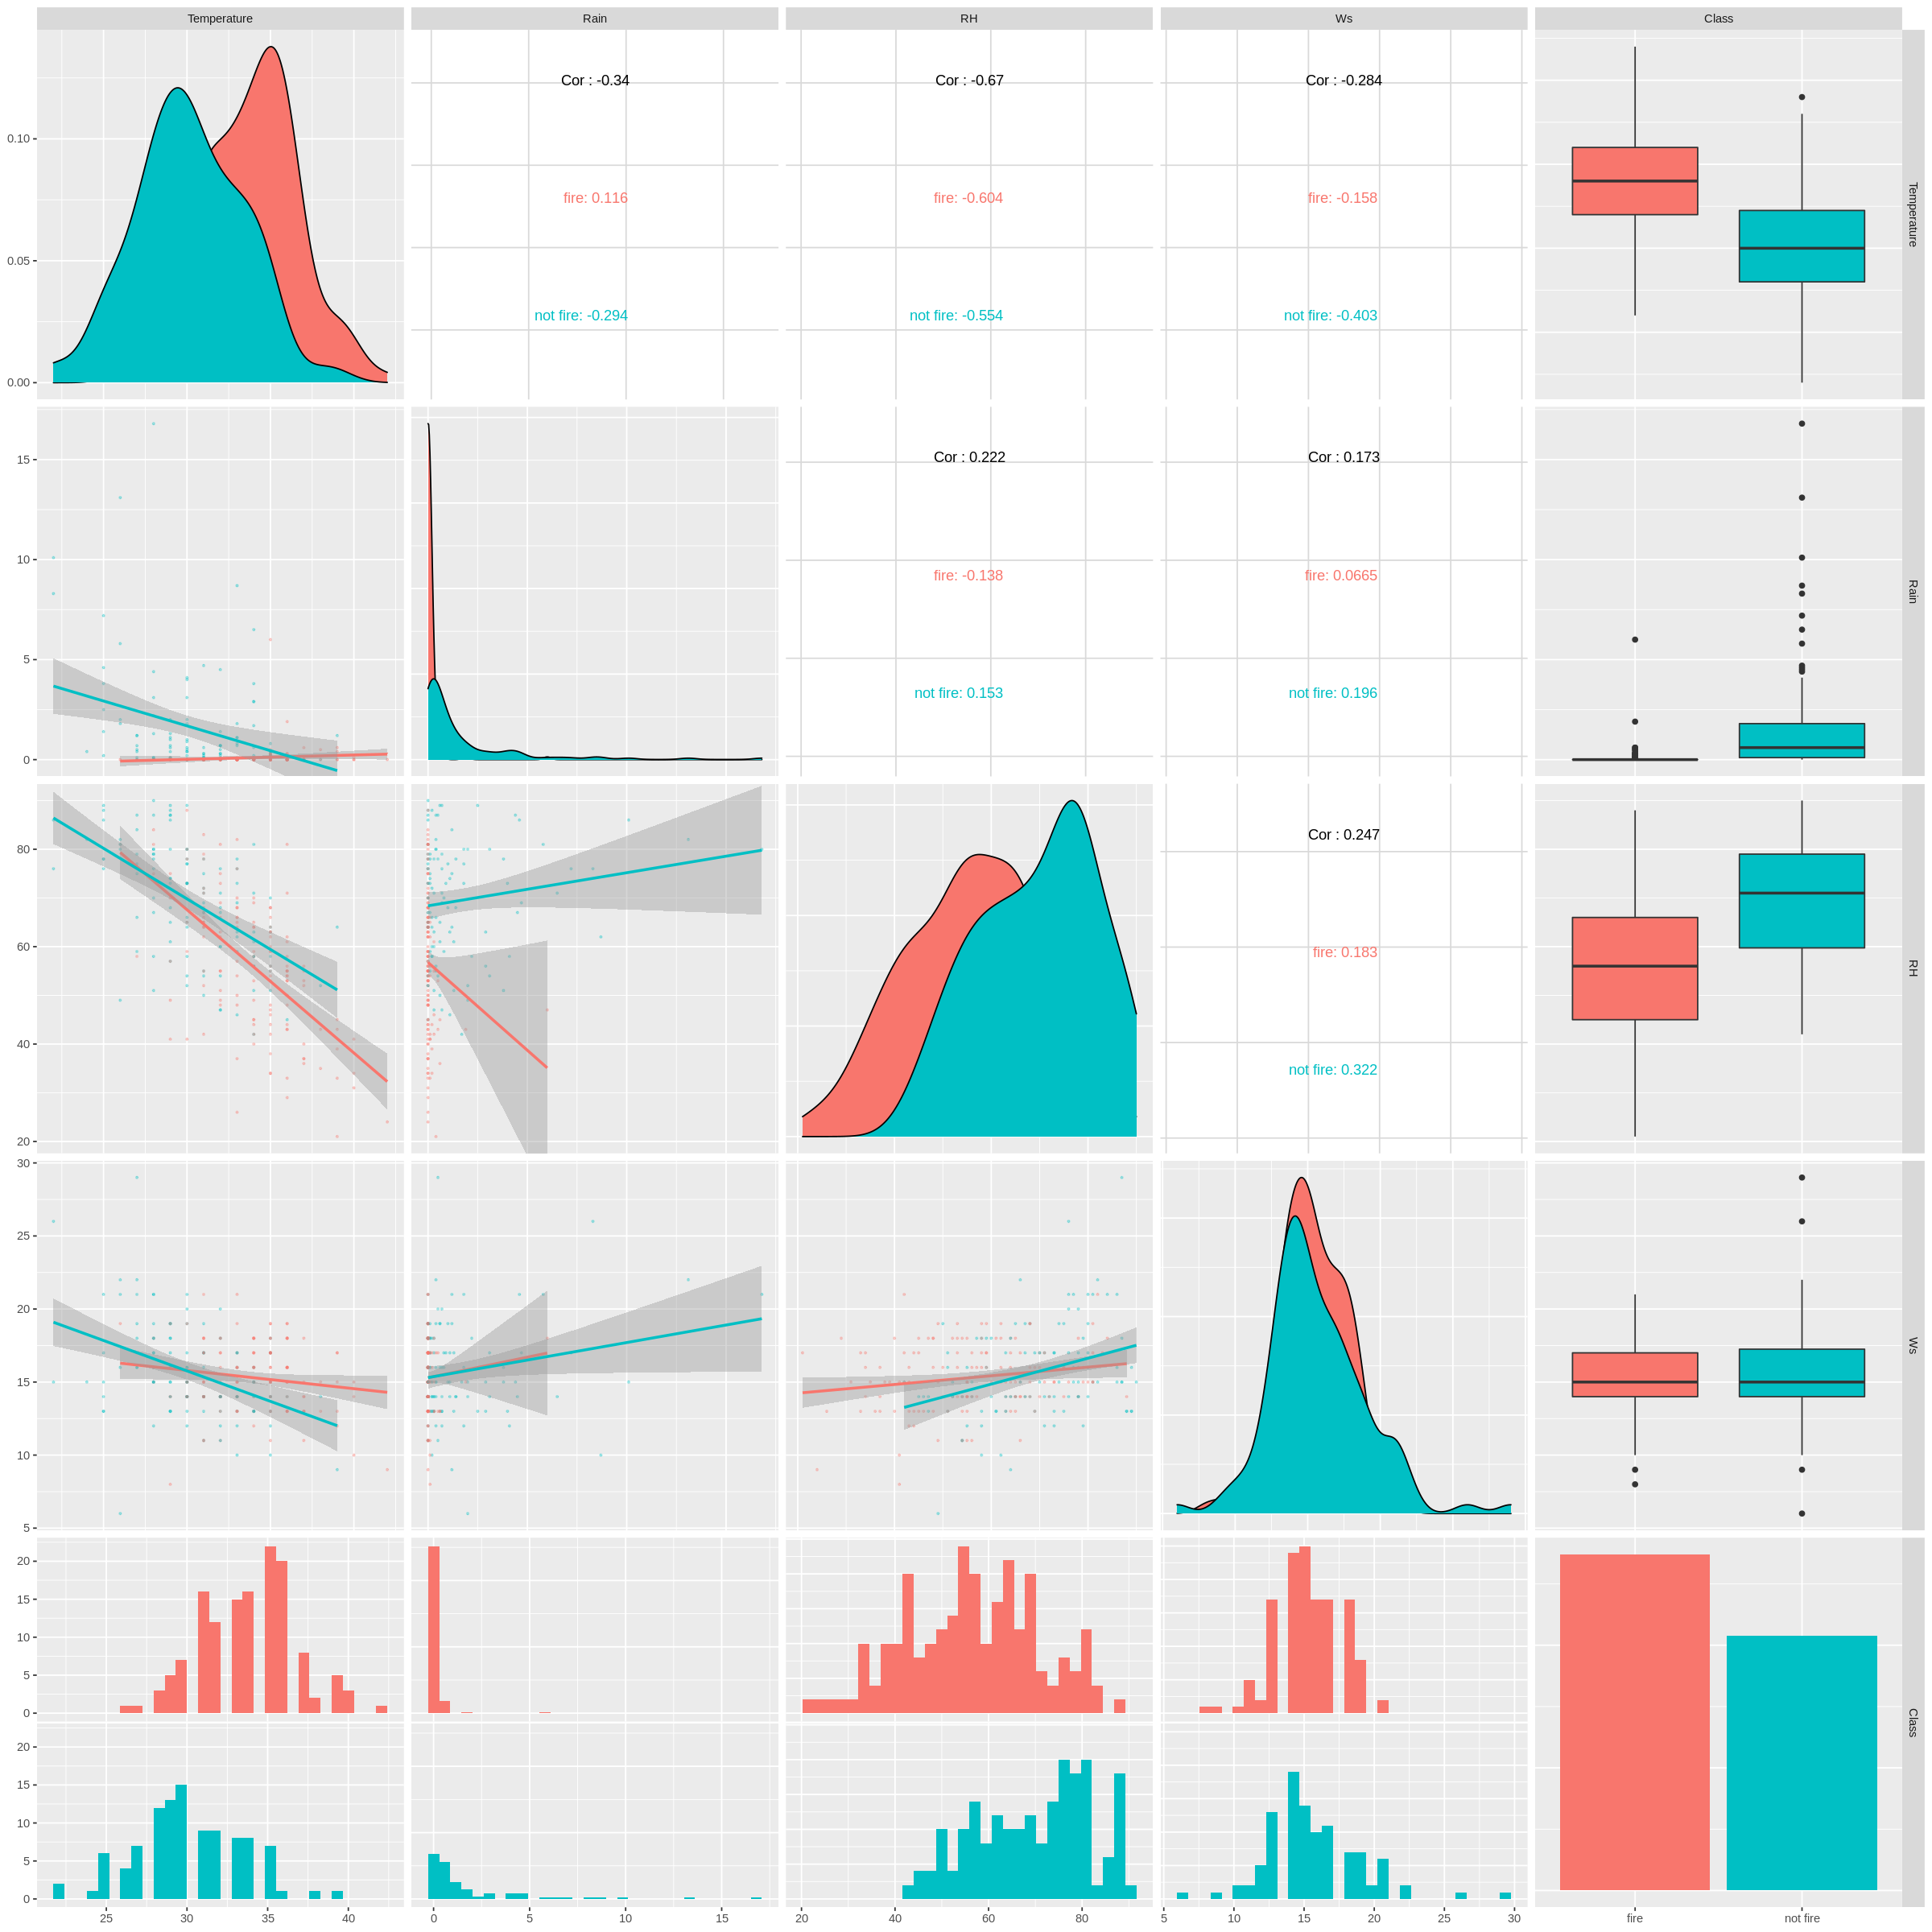

In [121]:
options(repr.plot.width = 20, repr.plot.height = 20)
forest_fire %>% 
        select(Temperature, Rain, RH, Ws, Class) %>%
        ggpairs(., 
               mapping = ggplot2::aes(colour=Class), 
               lower = list(continuous = wrap("smooth", alpha = 0.3, size=0.5)))

<i>Figure 2: Smoothed distribution matrix illustrating the differences in each variables properties for both the two target classes. All of these variables except for wind speed show significant differences between the two classes. This matrix is also useful for identifying multicollinearity between variables, as if this is there are strong linear correlations between two variables, they are no longer "independent" variables. </i>

Through the examination of data above, the variables temperature, rain, and relative humidity were chosen as predictors for the model.

In [122]:
forest_fire_split <- initial_split(forest_fire, prop = 0.75, strata = Class)  
forest_fire_train <- training(forest_fire_split)   
forest_fire_test <- testing(forest_fire_split)

In [123]:
#The outputted dataframes of the following cell show the averages of temperature and rain for all the observations, 
#as well as the number of fire/non-fire days there were for the 244 days observed. 

forest_fire_means <- forest_fire_train %>%
    select(Temperature, Rain) %>%
    map_df(mean, na.rm = TRUE)

forest_fire_means

forest_fire_classes <- forest_fire_train %>%
    group_by(Class) %>%
    summarize(count = n())

forest_fire_classes

Temperature,Rain
<dbl>,<dbl>
32.20994,0.7314917


`summarise()` ungrouping output (override with `.groups` argument)



Class,count
<fct>,<int>
fire,103
not fire,78


In [124]:
#scale the variables
# forest_fire_train_scaled <- forest_fire_train %>% 
#  mutate(scaled_Temp = scale(Temperature, center = TRUE), 
#         scaled_RH = scale(RH, center = TRUE),
#         scaled_Ws = scale(Ws, center = TRUE),
#         scaled_Rain = scale(Rain, TRUE),
#         scaled_FFMC = scale(FFMC, TRUE),
#         scaled_DMC = scale(DMC, TRUE),
#         scaled_DC = scale(DC, TRUE),
#         scaled_ISI = scale(ISI, TRUE),
#         scaled_BUI = scale(BUI, TRUE),
#         scaled_FWI = scale(FWI, TRUE),
#         Fire_Status = Classes) %>%
# select(scaled_Temp:Fire_Status)

# head(forest_fire_train_scaled) #we changed it to forest_fire_train because we are only supposed to scale the training data. 

In [125]:
# #split dataset into a training and testing set
# wildfire_split <- initial_split(wildfire_scaled, prop = 0.75, strata = Fire_Status)  
# wildfire_train <- training(wildfire_split)   
# wildfire_test <- testing(wildfire_split)

#head(wildfire_train)
#head(wildfire_test)

In [126]:
# wildfire_means <- wildfire_train %>%
#     map_df(mean)

# wildfire_means

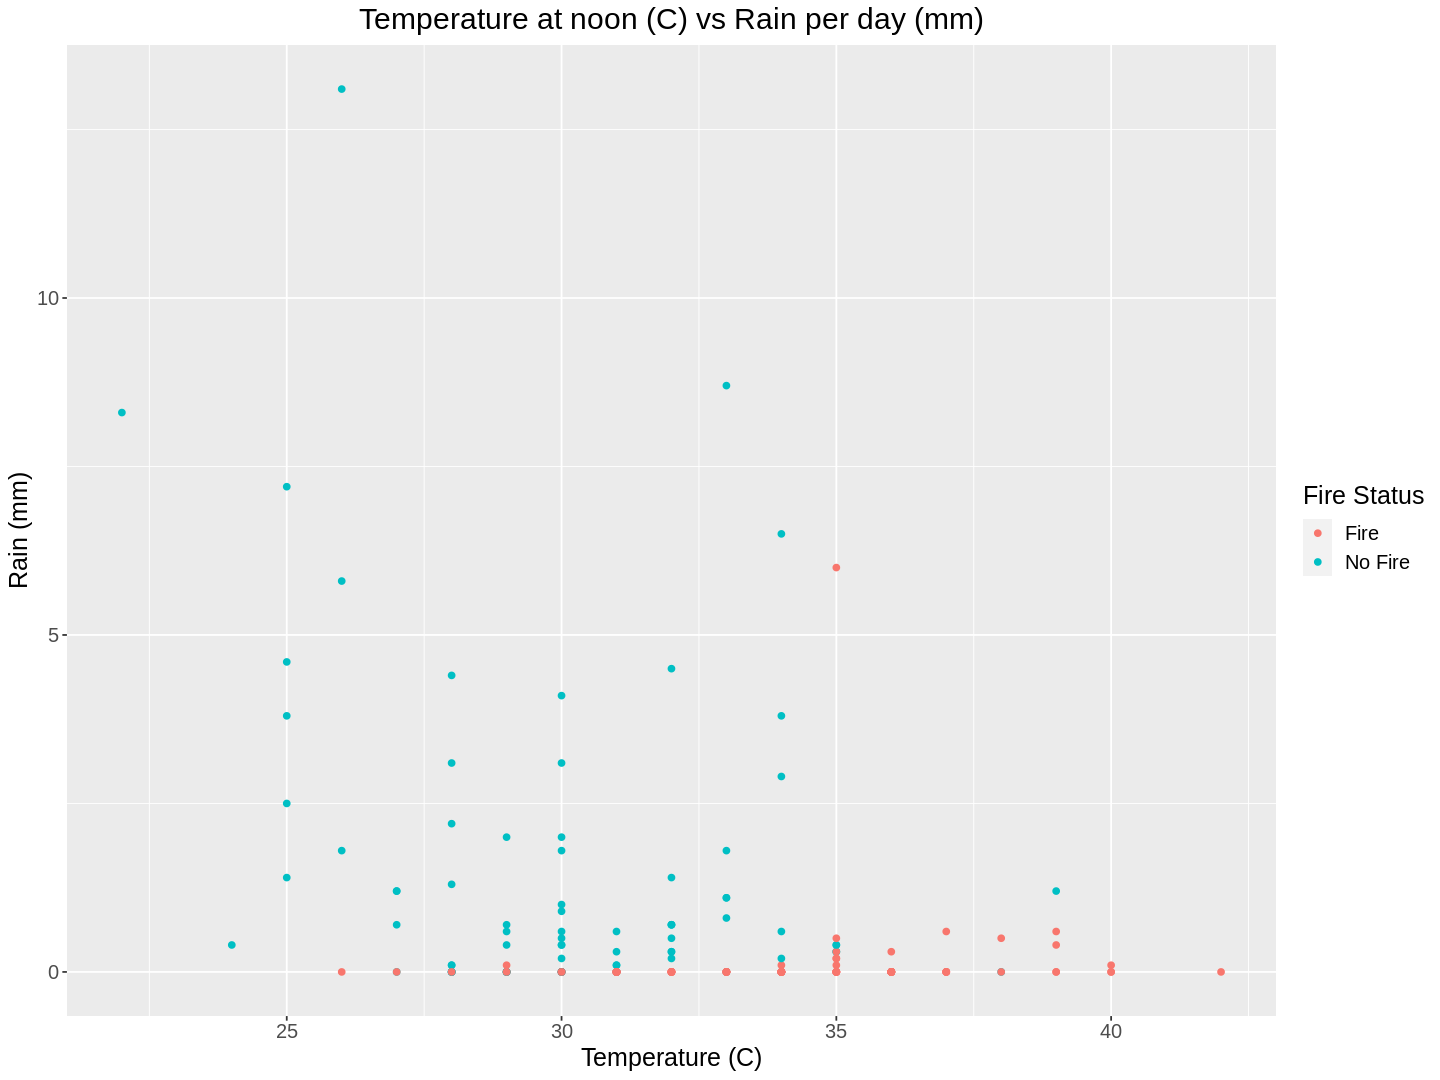

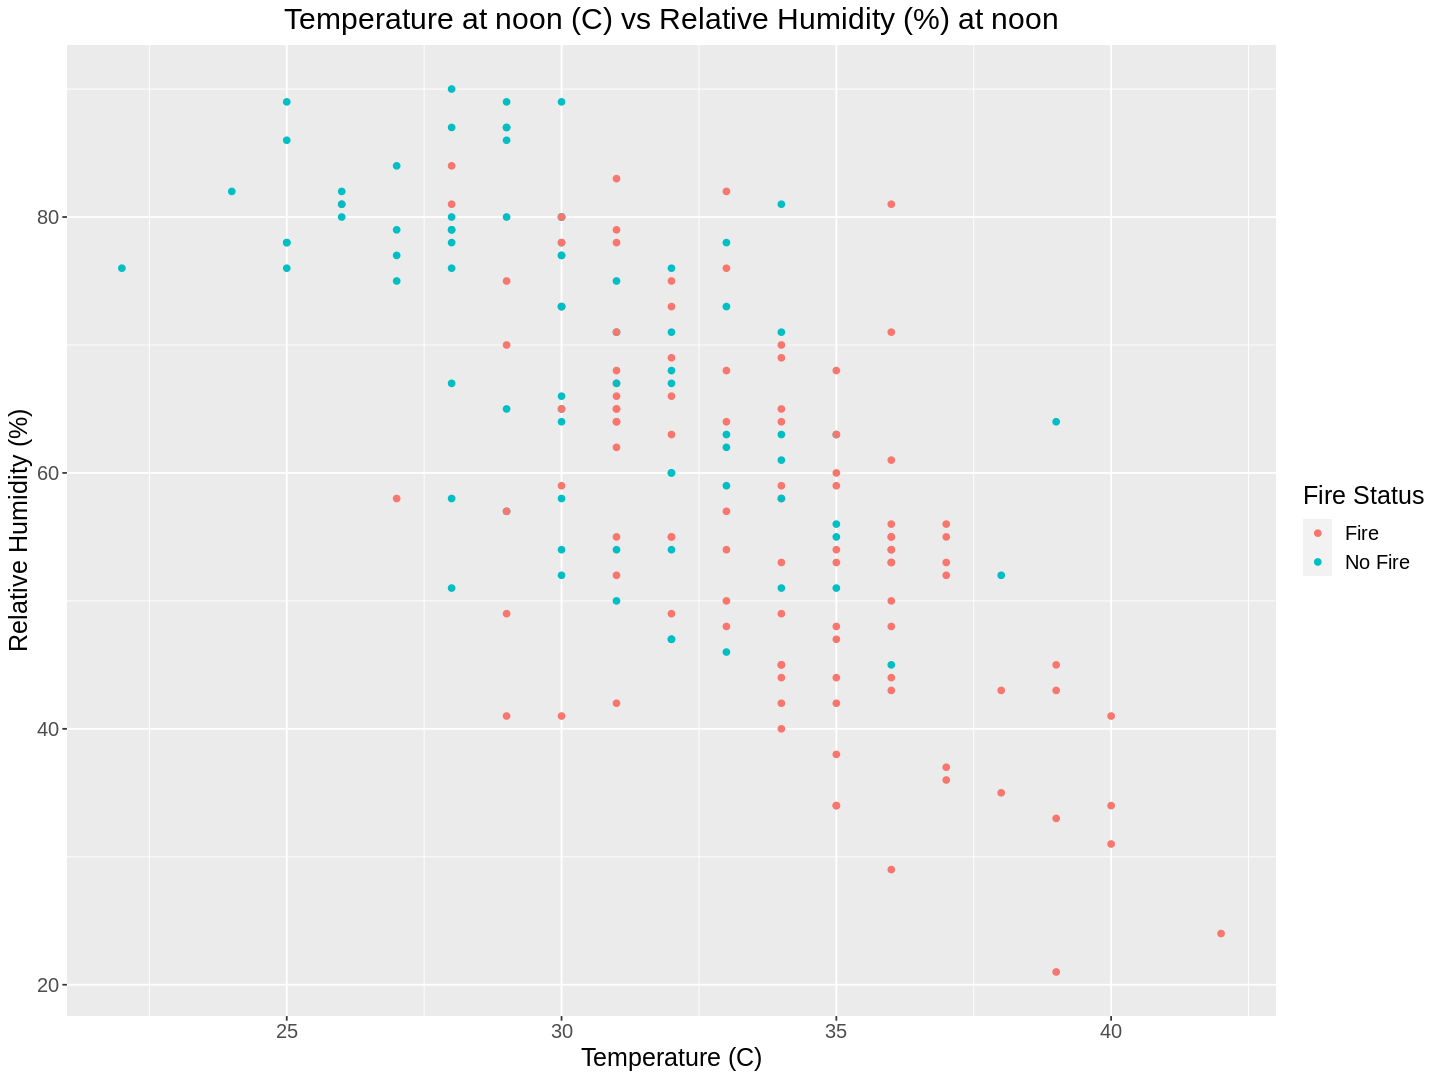

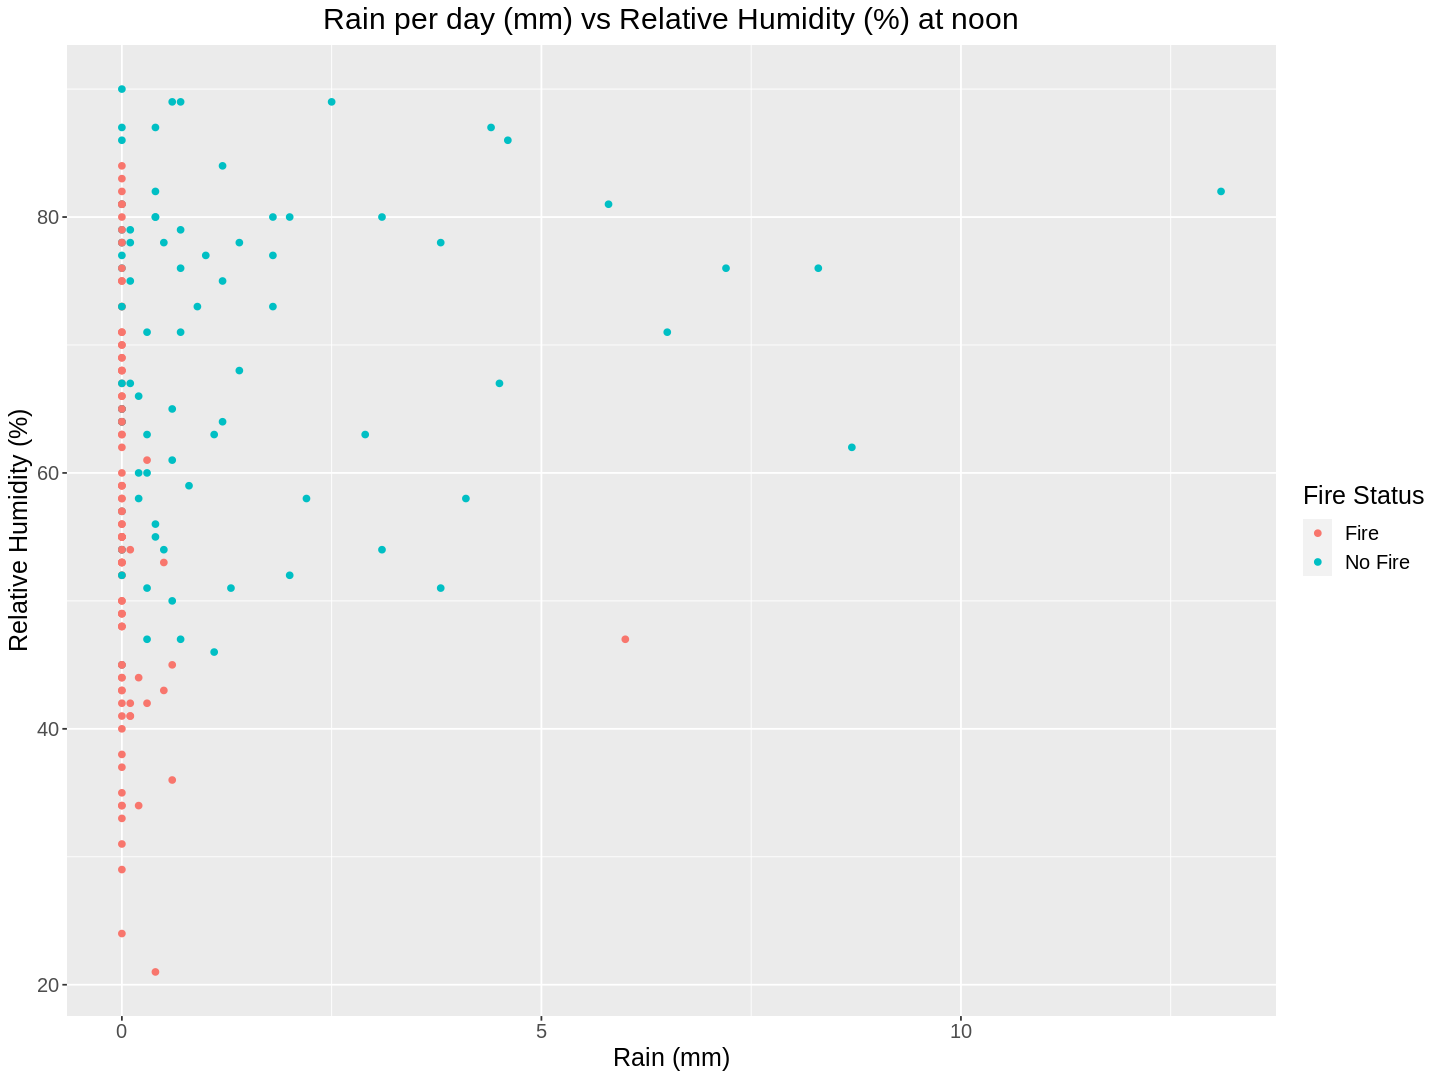

In [127]:
options(repr.plot.width = 12, repr.plot.height = 9)

temperature_rain_plot <- ggplot(forest_fire_train, aes(x = Temperature, y = Rain, colour = Class)) + #training set, not whole dataset
  geom_point() +
  labs(x = "Temperature (C)", y = "Rain (mm)", colour = "Fire Status") +
  ggtitle("Temperature at noon (C) vs Rain per day (mm)") +
  theme(plot.title = element_text(hjust = 0.5)) +
  theme(text = element_text(size = 15)) +
  scale_color_discrete(labels = c("Fire", "No Fire", "Unknown")) #no unknowns though
temperature_rain_plot

temperature_relative_humidity_plot <- ggplot(forest_fire_train, aes(x = Temperature, y = RH, colour = Class)) + #training set, not whole dataset
  geom_point() +
  labs(x = "Temperature (C)", y = "Relative Humidity (%)", colour = "Fire Status") +
  ggtitle("Temperature at noon (C) vs Relative Humidity (%) at noon") +
  theme(plot.title = element_text(hjust = 0.5)) +
  theme(text = element_text(size = 15)) +
  scale_color_discrete(labels = c("Fire", "No Fire", "Unknown"))
temperature_relative_humidity_plot

rain_relative_humidity_plot <- ggplot(forest_fire_train, aes(x = Rain, y = RH, colour = Class)) + #training set, not whole dataset
  geom_point() +
  labs(x = "Rain (mm)", y = "Relative Humidity (%)", colour = "Fire Status") +
  ggtitle("Rain per day (mm) vs Relative Humidity (%) at noon") +
  theme(plot.title = element_text(hjust = 0.5)) +
  theme(text = element_text(size = 15)) +
  scale_color_discrete(labels = c("Fire", "No Fire", "Unknown"))
rain_relative_humidity_plot

#summarize training data
#training data plot

**Methods:** 

The data analysis will be conducted using the scaled_Temp and scaled_Rain (temperature and rain scaled). Since the dataset is a small dataset, the training and testing sets are split 75-25. Then, the recipe will be created using the training set. The number of neighbours used will be found from tuning the initial training set by splitting it in different ways into multiple validation and training sets then cross validating for accuracy.

Our results will be visualized by using the geom_point() function to display the observations in the validation set with respect to temperature at noon and amount of rain per day, coloured by the classification of fire or not fire.

**Expected Outcomes and Project Significance:**

Intuition suggests that higher noon temperatures and lower daily rain  (leading to dryer conditions) would lead to a higher probability of wildfire occurrence.

Establishing a reliable classification model ensures that, by  measuring these predictive variables, more informed decisions can be made on any given day to better deal with or contain potential wildfires when and where they are more likely to occur. Adequate resources may be allocated in advance using weather forecasts, and warnings of potential fires can be announced through media like weather channels in a timely fashion.

Investigating  the intersection of wildfire predictability and climate conditions could lead to intriguing territory with regards to the discussion of climate change; that is, if the occurrence of wildfires can be accurately predicted using the chosen variables, which are natural phenomena, and climate change has a significant effect on said phenomena, an intuitive follow-up question could be asked, “Does anthropogenic climate change increase wildfire frequency?”

### Creating the Recipe and Specifications

Since K-nearest neighbours is sensitive to the scale of the predictors, the predictors will need to be scaled and then centered. The recipe will be created using the training data using the predictor variables of temperature, rain, and relative humidity.

In [128]:
forest_fire_recipe <- recipe(Class ~ Temperature + Rain + RH, data = forest_fire_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())
forest_fire_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

The specification for the model will use the function tune() for the number of neighbours and a rectangular weight function. Since the model using K-nearest neighbours, the engine will be set to kknn.

In [129]:
forest_fire_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")

### Picking the K Value for the Model

To pick a k value for the model, the training data will need to be tuned. Performing a cross-validation is the best way to accomplish this so that the k value will not depend on chance. The cross-validation will be conducted with 5 folds. Although any number of folds could be chosen, 5 and 10 are commonly used and therefore 5 was chosen.

In [130]:
forest_fire_vfold <- vfold_cv(forest_fire_train, v = 5, strata = Class)

In [131]:
gridvals <- tibble(neighbors = seq(1:20))
forest_fire_accuracies <- workflow() %>%
    add_recipe(forest_fire_recipe) %>%
    add_model(forest_fire_tune) %>%
    tune_grid(resamples = forest_fire_vfold, grid = gridvals) %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")
forest_fire_accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7578378,5,0.02443451,Model01
2,accuracy,binary,0.7578378,5,0.02588612,Model02
3,accuracy,binary,0.7842471,5,0.02062889,Model03
4,accuracy,binary,0.7842471,5,0.02062889,Model04
5,accuracy,binary,0.7959846,5,0.02379130,Model05
6,accuracy,binary,0.7848649,5,0.01972455,Model06
7,accuracy,binary,0.7629344,5,0.01917174,Model07
8,accuracy,binary,0.7629344,5,0.01917174,Model08
9,accuracy,binary,0.7740541,5,0.02703541,Model09


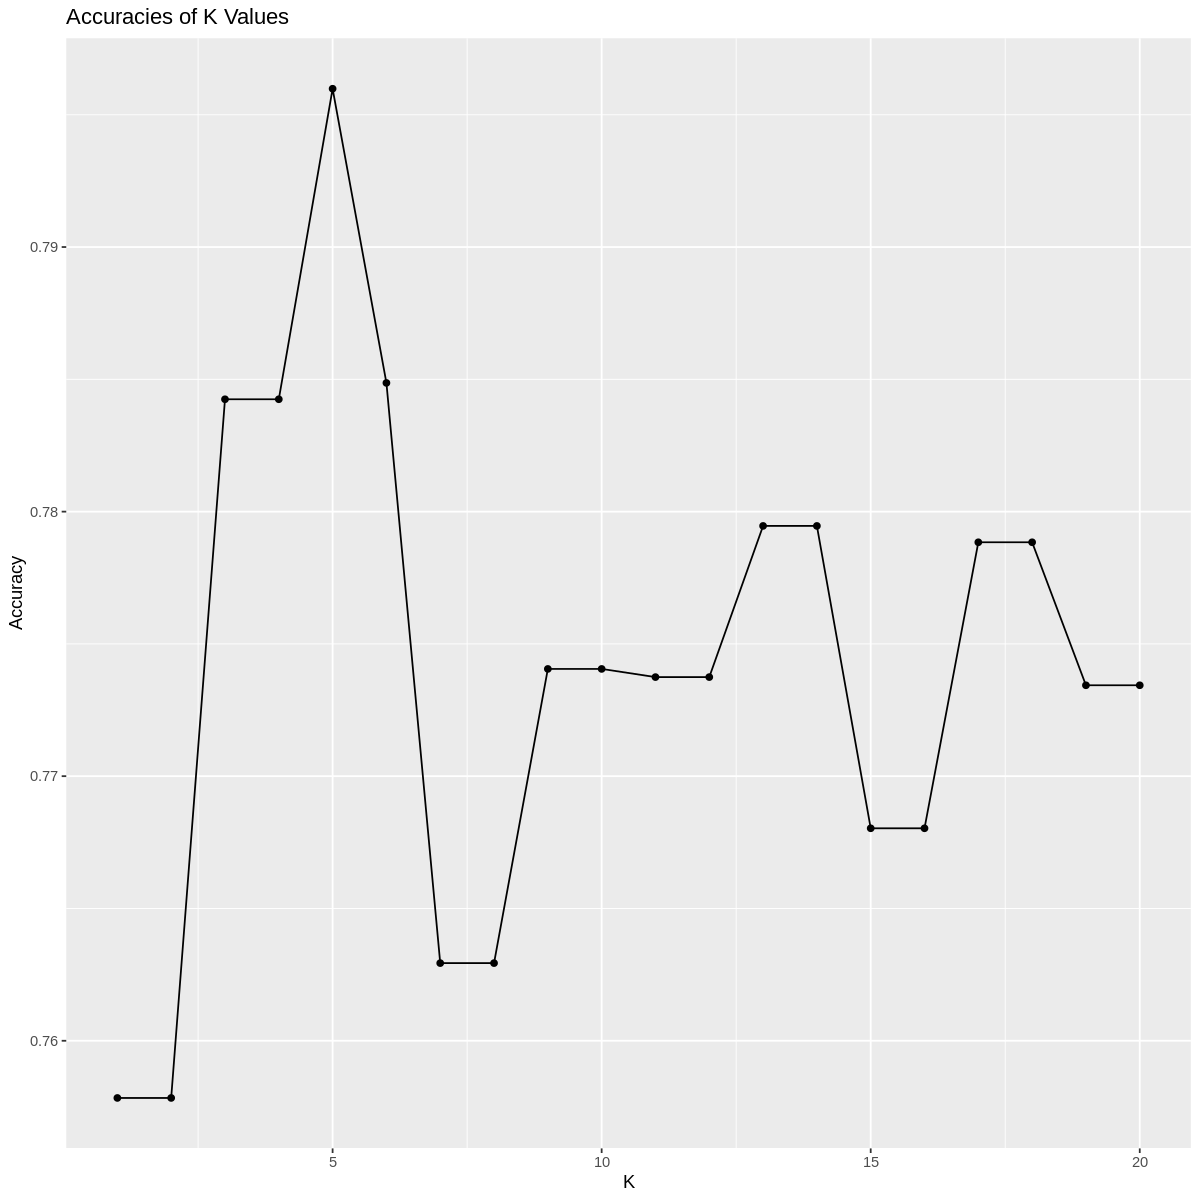

In [132]:
options(repr.plot.width = 10, repr.plot.height = 10)
forest_fire_accuracies_plot <- forest_fire_accuracies %>%
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "K", y = "Accuracy") + 
        ggtitle("Accuracies of K Values")
forest_fire_accuracies_plot

Looking at the **plot above**, k = 5 has the highest accuracy when classifying the fires, across all k values. Therefore, the final model will use 5 neighbours to predict the testing data.

### Building the Model

In [133]:
forest_fire_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
      set_engine("kknn") %>%
      set_mode("classification")

In [134]:
forest_fire_fit <- workflow() %>%
    add_recipe(forest_fire_recipe) %>%
    add_model(forest_fire_spec) %>%
    fit(data = forest_fire_train)
forest_fire_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~5, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1933702
Best kernel: rectangular
Best k: 5

In [135]:
forest_fire_predictions <- predict(forest_fire_fit, forest_fire_test) %>%
      bind_cols(forest_fire_test)

forest_fire_metrics <- forest_fire_predictions %>%
        metrics(truth = Class, estimate = .pred_class)   
forest_fire_metrics

forest_fire_conf_mat <- forest_fire_predictions %>%
    conf_mat(truth = Class, estimate = .pred_class)
forest_fire_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8000000
kap,binary,0.5774648


          Truth
Prediction fire not fire
  fire       32       10
  not fire    2       16

## References:

Berdikeeva, S. (2019). Burning Forests Threaten At-Risk Populations in Morocco and Algeria. Inside Arabia. Retrieved 7 April 2021, from https://insidearabia.com/burning-forests-threaten-at-risk-populations-in-morocco-and-algeria/.

Kharytonov, M., Islem, B., & Maatoug, M. (2018). Vegetation dynamics of Algerian’s steppe ecosystem. Case of the region of Tiaret. Environmental Research, Engineering And Management, 74(1). https://doi.org/10.5755/j01.erem.74.1.20095

Law, J. (2019). Algerian forest reinstated as National Park after turbulent history. BirdLife. Retrieved 7 April 2021, from https://www.birdlife.org/worldwide/news/algerian-forest-reinstated-national-park-after-turbulent-history.

Meddour-Sahar, Ouahiba; González-Cabán, Armando; Meddour, Rachid; Derridj, Arezki. (2013). Wildfire management policies in Algeria: present and future needs. In: González-Cabán, Armando, tech. coord. Proceedings of the fourth international symposium on fire economics, planning, and policy: climate change and wildfires. Gen. Tech. Rep. PSW-GTR-245 (English). Albany, CA: U.S. Department of Agriculture, Forest Service, Pacific Southwest Research Station: 382-395.

National Wildfire Coordinating Group. (2021). Fire Weather Index (FWI) System. *FWI Process Flow Chart* [image]. Retrieved 12 April 2021, from https://www.nwcg.gov/publications/pms437/cffdrs/fire-weather-index-system.

Natural Resources Canada. (2020). Fire behaviour. Retrieved 7 April 2021, from https://www.nrcan.gc.ca/our-natural-resources/forests-forestry/wildland-fires-insects-disturban/forest-fires/fire-behaviour/13145.